In [1]:
# !pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

Importing the processor and the InstructBlip model

In [2]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch

# processor
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")
# model
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b", load_in_4bit=True, torch_dtype=torch.float16)

2024-03-24 11:53:51.897294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 11:53:51.897396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 11:53:52.062483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


qformer_tokenizer/tokenizer_config.json:   0%|          | 0.00/343 [00:00<?, ?B/s]

qformer_tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

qformer_tokenizer/tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

qformer_tokenizer/added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

(…)former_tokenizer/special_tokens_map.json:   0%|          | 0.00/149 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/442 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.66k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


pytorch_model.bin.index.json:   0%|          | 0.00/107k [00:00<?, ?B/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/9.92G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Checking a sample image

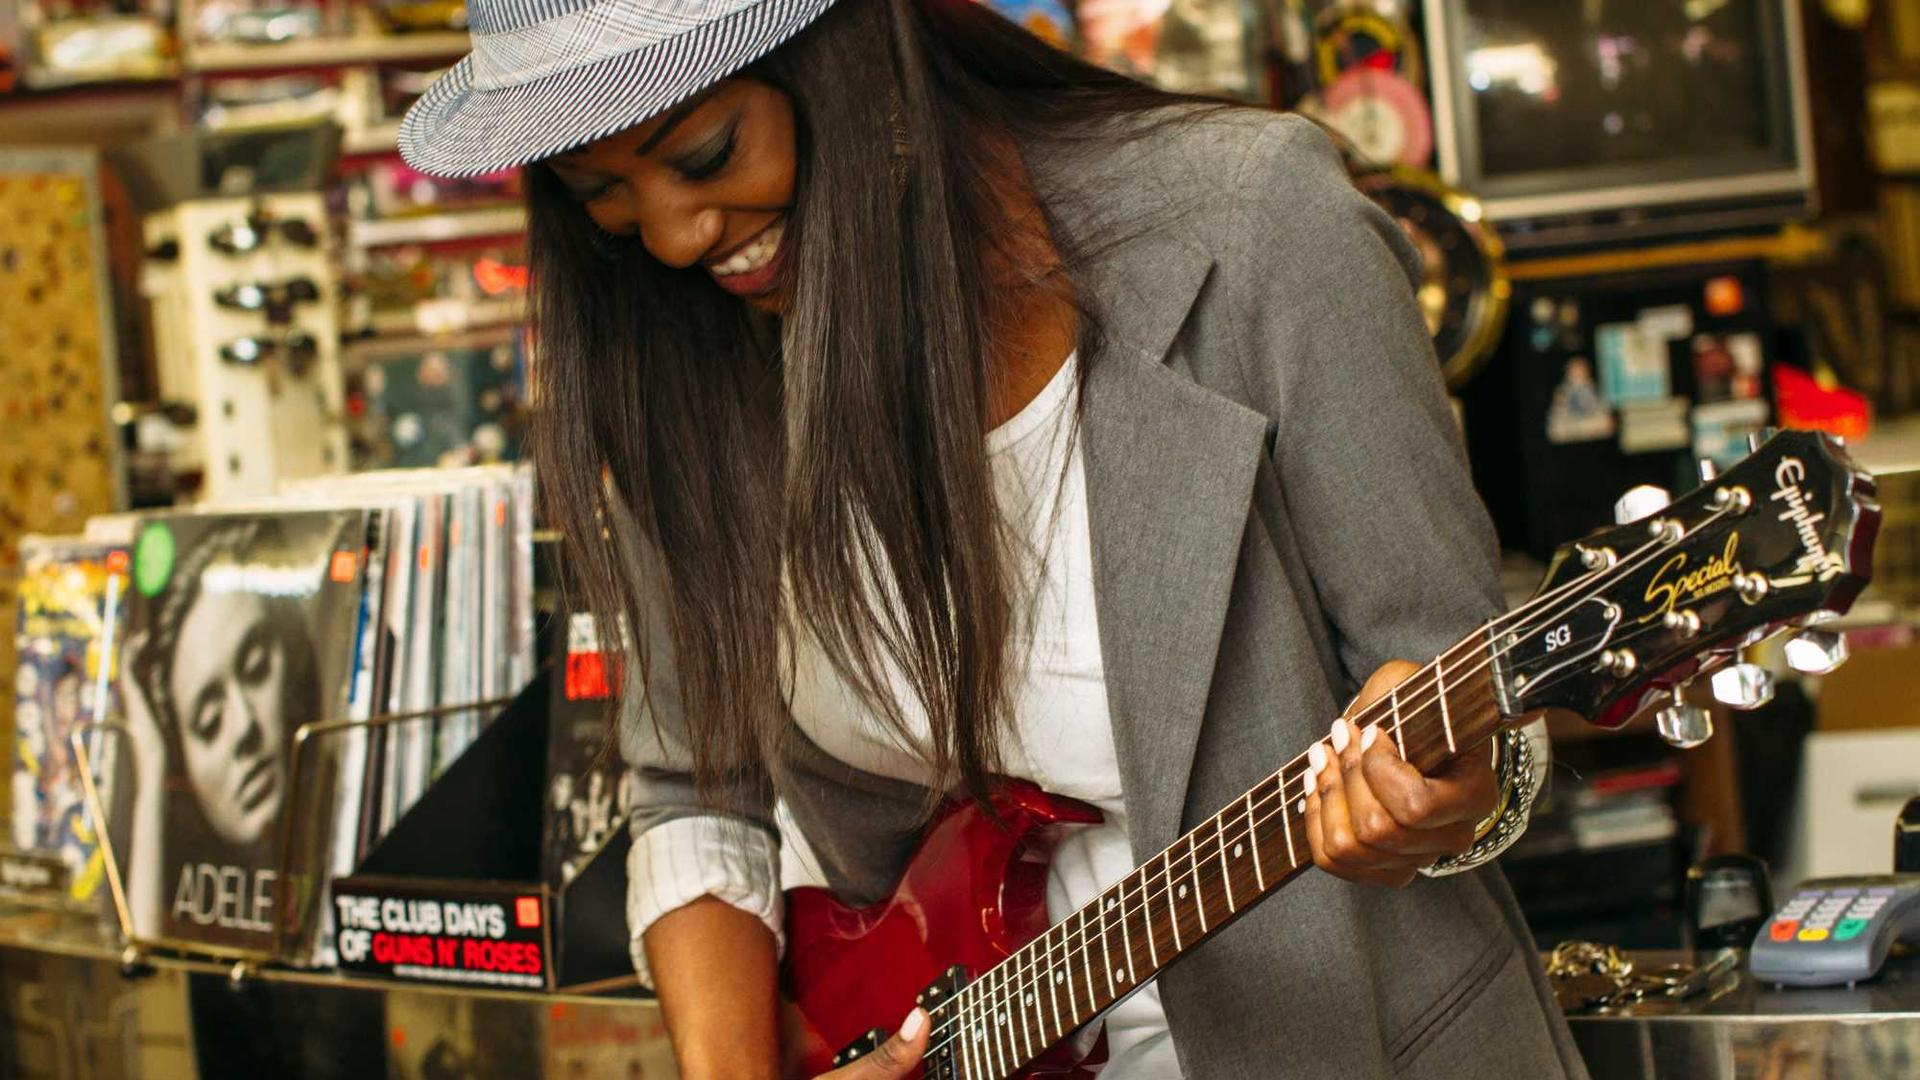

In [36]:
from PIL import Image
import requests

# url = "https://raw.githubusercontent.com/salesforce/LAVIS/main/docs/_static/Confusing-Pictures.jpg"
image = Image.open("/kaggle/input/image-dataset/image-20.jpg").convert("RGB")
image

Create description of the image using Instruct Blip

In [56]:
import csv

# prompt for the model
prompts = ["create the description of main figure in the image",
           "create the desciption of everything except the main figure",
           "create the perfect desciption of the scene"]

csv_file_path = 'image_desc.csv'

# open the csv_file of images
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'Description'])

    # iterate over the images
    for idx in range(1,51):
        image = Image.open(f"/kaggle/input/image-dataset/image-{idx}.jpg").convert("RGB")
        desc = ""
        for prompt in prompts:
            inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)
            outputs = model.generate(
                    **inputs,
                    do_sample=True,
                    min_length=50,
                    repetition_penalty=1.5,
                    length_penalty=1.0,
                    temperature=1,
            )
            generated_text = processor.batch_decode(
              outputs,
              skip_special_tokens = True,
            )[0].strip()
            desc += generated_text + " "

        writer.writerow([idx, desc])
        torch.cuda.empty_cache()